In [1]:
import torch
import torch.nn as nn
import numpy as np

# Causal Mask
def Causal_Mask(seq_len, device): 
    mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
    mask = mask.masked_fill(mask == 1, float("-inf"))
    return mask

# Embedding for tokens
class Embedder(nn.Module): 
    def __init__(self, vocab_size, embedding_dim, padding_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)

    def forward(self, x):
        return self.embedding(x)

# Positional Encoding
class PositionalEncoder(nn.Module): 
    def __init__(self, embedding_dim, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-np.log(10000.0) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: [1, max_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class DescriptorEncoder(nn.Module): 
    def __init__(self, desc_size, emb_dim, dropout=0.1, device='cuda'):
        super().__init__()
        self.desc_size = desc_size
        self.device = device
        self.bit_emb = nn.Embedding(desc_size, emb_dim)  # 各特徴の意味ベクトル
        self.scale_norm = nn.LayerNorm(1)                # 値のスケーリング安定化
        self.dropout = nn.Dropout(dropout)

    def forward(self, desc):  # desc: [B, D], float
        B, D = desc.shape
        assert D == self.desc_size, "Input descriptor dim must match initialized size"

        bit_idx = torch.arange(D, device=self.device).unsqueeze(0).expand(B, D)  # [B, D]
        bit = self.bit_emb(bit_idx)                  # [B, D, emb]
        val = self.scale_norm(desc.unsqueeze(-1))    # [B, D, 1]
        emb = self.dropout(bit * val)                # [B, D, emb]
        return emb


# Self-Attention Layer
class SelfAttentionLayer(nn.Module):
    def __init__(self, embedding_dim, n_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embedding_dim, n_heads, batch_first=True)

    def forward(self, x):
        seq_len = x.size(1)
        mask = Causal_Mask(seq_len, x.device)
        attn_output, _ = self.attention(x, x, x, attn_mask=mask)
        return attn_output

# FeedForward Layer
class FeedForwardLayer(nn.Module):
    def __init__(self, embedding_dim, feedforward_dim):
        super().__init__()
        self.feedforward = nn.Sequential(
            nn.Linear(embedding_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, embedding_dim)
        )

    def forward(self, x):
        return self.feedforward(x)

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, n_heads, feedforward_dim):
        super().__init__()
        self.self_attn = SelfAttentionLayer(embedding_dim, n_heads)
        self.feed_forward = FeedForwardLayer(embedding_dim, feedforward_dim)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        x2 = self.self_attn(x)
        x = self.norm1(x + x2)
        x2 = self.feed_forward(x)
        x = self.norm2(x + x2)
        return x

# MolGPT Self-Attention Model
class MolGPT_SelfAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, padding_idx, n_heads, feedforward_dim, n_layers, desc_size):
        super().__init__()
        self.embedder = Embedder(vocab_size, embedding_dim, padding_idx)
        self.descriptor_encoder = DescriptorEncoder(desc_size, embedding_dim)
        self.positional_encoder = PositionalEncoder(embedding_dim)
        self.dropout = nn.Dropout(0.1)

        self.layers = nn.ModuleList([
            TransformerBlock(embedding_dim, n_heads, feedforward_dim)
            for _ in range(n_layers)
        ])
        self.output_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x, desc):
        token_emb = self.embedder(x)                          # [B, T, D]
        desc_emb = self.descriptor_encoder(desc)              # [B, D1, D]
        combined = torch.cat([desc_emb, token_emb], dim=1)    # [B, D1+T, D]
        combined = self.positional_encoder(combined)
        combined = self.dropout(combined)

        x = combined  # already [B, L, D] due to batch_first=True

        for layer in self.layers:
            x = layer(x)

        logits = self.output_layer(x)                         # [B, D1+T, vocab]
        return logits[:, desc_emb.size(1):, :]                # return only token part


In [2]:
import re
import torch

class SMILESTokenizer:
    def __init__(self):
        # 固定トークンセット（既に定義済み）
        self.tokens = ['#', '%10', '%11', '%12', '(', ')', '-', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<', '=', 'B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S',
            '[B-]', '[BH-]', '[BH2-]', '[BH3-]', '[B]', '[C+]', '[C-]', '[CH+]', '[CH-]', '[CH2+]', '[CH2]', '[CH]', '[F+]', '[H]', '[I+]', '[IH2]', '[IH]', '[N+]', '[N-]',
            '[NH+]', '[NH-]', '[NH2+]', '[NH3+]', '[N]', '[O+]', '[O-]', '[OH+]', '[O]', '[P+]', '[PH+]', '[PH2+]', '[PH]', '[S+]', '[S-]', '[SH+]', '[SH]', '[Se+]', 
            '[SeH+]', '[SeH]', '[Se]', '[Si-]', '[SiH-]', '[SiH2]', '[SiH]', '[Si]', '[b-]', '[bH-]', '[c+]', '[c-]', '[cH+]', '[cH-]', '[n+]', '[n-]', '[nH+]', '[nH]', 
            '[o+]', '[s+]', '[sH+]', '[se+]', '[se]', 'b', 'c', 'n', 'o', 'p', 's']

        # 特殊トークン
        self.special_tokens = ['<BOS>', '<EOS>', '<PAD>', '<UNK>']
        self.pad_token = '<PAD>'
        self.bos_token = '<BOS>'
        self.eos_token = '<EOS>'
        self.unk_token = '<UNK>'

        # 語彙構築（固定）
        all_tokens = self.special_tokens + self.tokens
        self.vocab = {token: idx for idx, token in enumerate(all_tokens)}
        self.reverse_vocab = {idx: token for token, idx in self.vocab.items()}

        # トークンパターン
        self.pattern = re.compile(
            r'%\d{2}|\[[^\]]+\]|Cl|Br|Si|Se|As|B|C|N|O|F|P|S|I|[cnospb]|[0-9]|\(|\)|=|#|-|\/|\\|\.|<'
        )

    def tokenize(self, smiles):
        return self.pattern.findall(smiles)

    def encode(self, smiles):
        tokens = [self.bos_token] + self.tokenize(smiles) + [self.eos_token]
        return [self.vocab.get(token, self.vocab[self.unk_token]) for token in tokens]

    def decode(self, token_ids):
        tokens = [self.reverse_vocab.get(int(i), self.unk_token) for i in token_ids]
        return ''.join([t for t in tokens if t not in self.special_tokens and t != self.pad_token])

    def masking_tokens(self, token_ids):
        inputs = token_ids[:-1]
        labels = token_ids[1:]
        return torch.tensor(inputs, dtype=torch.long), torch.tensor(labels, dtype=torch.long)



In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import MACCSkeys
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# read smiles txt
with open(r'C:\Users\taiki\IT\OPS_AGI\molGPT\data\ZINC\250k_rndm_zinc_drugs_clean.txt', 'r') as file:
    smiles_lists = [line.strip() for line in file.readlines()]

tokenizer = SMILESTokenizer()
print(len(tokenizer.vocab))


98


In [4]:
# encoding
encoded_data = [tokenizer.encode(smiles) for smiles in smiles_lists]
# masking
data = [tokenizer.masking_tokens(tokens) for tokens in encoded_data]

# descriptor計算
def get_descriptor(smiles, descriptor_type='RDKit'):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        if descriptor_type == 'RDKit':
            descriptors = []
            for name, func in Descriptors._descList:
                try:
                    val = func(mol)
                    # NaN, inf の除去（floatで有限な値だけ通す）
                    descriptors.append(val if np.isfinite(val) else 0.0)
                except:
                    # 計算エラーも含めて0.0にしておく（または np.nan でも可）
                    descriptors.append(0.0)
            return np.array(descriptors, dtype=np.float32)
        
        elif descriptor_type == 'MACCS':
            maccs_fp = MACCSkeys.GenMACCSKeys(mol)
            arr = np.zeros((maccs_fp.GetNumBits(),), dtype=np.float32)
            # ビットをnumpy配列にコピー
            for i in range(maccs_fp.GetNumBits()):
                arr[i] = maccs_fp.GetBit(i)
            return arr
        
        else:
            raise ValueError("Unknown descriptor type: choose 'RDKit' or 'MACCS'")
    else:
        return None

# descriptorを一回だけ計算
descriptor_data = []
valid_data = []
for smiles, (tokens, labels) in zip(smiles_lists, data):
    descriptors = get_descriptor(smiles)
    if descriptors is not None:
        descriptor_data.append(descriptors)
        valid_data.append((tokens, labels))  # descriptorがNoneじゃないペアだけ保存

data = valid_data

# max_len計算（inputsだけで十分）
max_len = max(len(tokens) for tokens, _ in data)

# padding
padded_inputs = [
    torch.cat([tokens, torch.full((max_len - len(tokens),), tokenizer.vocab[tokenizer.pad_token], dtype=torch.long)])
    for tokens, _ in data
]
padded_labels = [
    torch.cat([labels, torch.full((max_len - len(labels),), tokenizer.vocab[tokenizer.pad_token], dtype=torch.long)])
    for _, labels in data
]

#scaling
scaler = StandardScaler()
descriptor_data_scaled = scaler.fit_transform(descriptor_data)
joblib.dump(scaler, "descriptor_scaler.pkl")

# to tensor
input_ids = torch.stack(padded_inputs)  
labels = torch.stack(padded_labels)     
descriptors = torch.tensor(descriptor_data_scaled, dtype=torch.float)

# create Dataloader
dataset = TensorDataset(input_ids, labels, descriptors)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f'inputs_size: {input_ids.size()}')
print(f'labels_size: {labels.size()}')
print(f'descriptors_size: {descriptors.size()}')


inputs_size: torch.Size([249456, 73])
labels_size: torch.Size([249456, 73])
descriptors_size: torch.Size([249456, 217])


In [5]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import numpy as np

# ==========================
# データ前処理: descriptorのNaN除去
# ==========================
descriptors = np.nan_to_num(descriptors, nan=0.0, posinf=1e6, neginf=-1e6)
# Tensorに変換し直す（もし必要なら）
descriptors = torch.tensor(descriptors, dtype=torch.float32)

# ==========================
# モデル・ハイパーパラメータ設定
# ==========================
vocab_size = len(tokenizer.vocab)
embedding_dim = 256
n_heads = 8
feedforward_dim = 512
n_layers = 8
desc_size = descriptors.size(1)
padding_idx = tokenizer.vocab[tokenizer.pad_token]
batch_size = 200
n_epochs = 100

# ==========================
# モデル初期化
# ==========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MolGPT_SelfAttention(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    padding_idx=padding_idx,
    n_heads=n_heads,
    feedforward_dim=feedforward_dim,
    n_layers=n_layers,
    desc_size=desc_size
).to(device)

# ==========================
# 損失関数・オプティマイザ・スケジューラ
# ==========================
criterion = nn.CrossEntropyLoss(ignore_index=padding_idx)

# 学習率を少し下げる
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=0.001)

warmup_steps = 1000
total_steps = (len(dataset) * 0.9 // batch_size) * n_epochs  # trainのみで計算

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    else:
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(5e-5, 0.5 * (1.0 + np.cos(np.pi * progress)))

scheduler = LambdaLR(optimizer, lr_lambda)

# ==========================
# データセット分割
# ==========================
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# ==========================
# 訓練ループ
# ==========================
best_valid_loss = float('inf')  # 最初は無限大にしておく
best_model_path = "molgpt_best_model.pth"  # 保存ファイル名

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    train_bar = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{n_epochs}")

    for batch in train_bar:
        input_ids, labels, descriptor = batch
        input_ids, labels, descriptor = input_ids.to(device), labels.to(device), descriptor.to(device)

        optimizer.zero_grad()

        logits = model(input_ids, descriptor)
        loss = criterion(logits.reshape(-1, vocab_size), labels.reshape(-1))
        loss.backward()

        # ✅ 勾配クリッピングで爆発防止！
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)

    # ==========================
    # Validation
    # ==========================
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids, labels, descriptor = batch
            input_ids, labels, descriptor = input_ids.to(device), labels.to(device), descriptor.to(device)

            logits = model(input_ids, descriptor)
            loss = criterion(logits.reshape(-1, vocab_size), labels.reshape(-1))
            valid_loss += loss.item()

    avg_valid_loss = valid_loss / len(valid_loader)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Valid Loss = {avg_valid_loss:.4f}")

    # ==========================
    # 最良モデル保存
    # ==========================
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved at epoch {epoch+1} with valid loss {best_valid_loss:.4f}!")

print(f"Training completed! Best model saved to {best_model_path}")


[Train] Epoch 1/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.79] 


Epoch 1: Train Loss = 1.2933, Valid Loss = 0.8422
✅ Best model saved at epoch 1 with valid loss 0.8422!


[Train] Epoch 2/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.726]


Epoch 2: Train Loss = 0.7404, Valid Loss = 0.6880
✅ Best model saved at epoch 2 with valid loss 0.6880!


[Train] Epoch 3/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.644]


Epoch 3: Train Loss = 0.6720, Valid Loss = 0.6613
✅ Best model saved at epoch 3 with valid loss 0.6613!


[Train] Epoch 4/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.67] 


Epoch 4: Train Loss = 0.6428, Valid Loss = 0.6405
✅ Best model saved at epoch 4 with valid loss 0.6405!


[Train] Epoch 5/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.637]


Epoch 5: Train Loss = 0.6237, Valid Loss = 0.6203
✅ Best model saved at epoch 5 with valid loss 0.6203!


[Train] Epoch 6/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.612]


Epoch 6: Train Loss = 0.6100, Valid Loss = 0.6094
✅ Best model saved at epoch 6 with valid loss 0.6094!


[Train] Epoch 7/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.596]


Epoch 7: Train Loss = 0.5990, Valid Loss = 0.6039
✅ Best model saved at epoch 7 with valid loss 0.6039!


[Train] Epoch 8/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.596]


Epoch 8: Train Loss = 0.5904, Valid Loss = 0.5959
✅ Best model saved at epoch 8 with valid loss 0.5959!


[Train] Epoch 9/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.58] 


Epoch 9: Train Loss = 0.5826, Valid Loss = 0.5919
✅ Best model saved at epoch 9 with valid loss 0.5919!


[Train] Epoch 10/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.575]


Epoch 10: Train Loss = 0.5762, Valid Loss = 0.5879
✅ Best model saved at epoch 10 with valid loss 0.5879!


[Train] Epoch 11/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.586]


Epoch 11: Train Loss = 0.5700, Valid Loss = 0.5846
✅ Best model saved at epoch 11 with valid loss 0.5846!


[Train] Epoch 12/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.589]


Epoch 12: Train Loss = 0.5649, Valid Loss = 0.5820
✅ Best model saved at epoch 12 with valid loss 0.5820!


[Train] Epoch 13/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.581]


Epoch 13: Train Loss = 0.5606, Valid Loss = 0.5800
✅ Best model saved at epoch 13 with valid loss 0.5800!


[Train] Epoch 14/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.568]


Epoch 14: Train Loss = 0.5557, Valid Loss = 0.5793
✅ Best model saved at epoch 14 with valid loss 0.5793!


[Train] Epoch 15/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.559]


Epoch 15: Train Loss = 0.5515, Valid Loss = 0.5758
✅ Best model saved at epoch 15 with valid loss 0.5758!


[Train] Epoch 16/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.548]


Epoch 16: Train Loss = 0.5482, Valid Loss = 0.5732
✅ Best model saved at epoch 16 with valid loss 0.5732!


[Train] Epoch 17/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.543]


Epoch 17: Train Loss = 0.5439, Valid Loss = 0.5719
✅ Best model saved at epoch 17 with valid loss 0.5719!


[Train] Epoch 18/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.565]


Epoch 18: Train Loss = 0.5408, Valid Loss = 0.5727


[Train] Epoch 19/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.534]


Epoch 19: Train Loss = 0.5375, Valid Loss = 0.5699
✅ Best model saved at epoch 19 with valid loss 0.5699!


[Train] Epoch 20/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.543]


Epoch 20: Train Loss = 0.5346, Valid Loss = 0.5697
✅ Best model saved at epoch 20 with valid loss 0.5697!


[Train] Epoch 21/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.514]


Epoch 21: Train Loss = 0.5314, Valid Loss = 0.5681
✅ Best model saved at epoch 21 with valid loss 0.5681!


[Train] Epoch 22/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.532]


Epoch 22: Train Loss = 0.5285, Valid Loss = 0.5678
✅ Best model saved at epoch 22 with valid loss 0.5678!


[Train] Epoch 23/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.526]


Epoch 23: Train Loss = 0.5257, Valid Loss = 0.5688


[Train] Epoch 24/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.543]


Epoch 24: Train Loss = 0.5229, Valid Loss = 0.5664
✅ Best model saved at epoch 24 with valid loss 0.5664!


[Train] Epoch 25/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.526]


Epoch 25: Train Loss = 0.5203, Valid Loss = 0.5680


[Train] Epoch 26/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.517]


Epoch 26: Train Loss = 0.5174, Valid Loss = 0.5704


[Train] Epoch 27/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.523]


Epoch 27: Train Loss = 0.5146, Valid Loss = 0.5679


[Train] Epoch 28/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.507]


Epoch 28: Train Loss = 0.5121, Valid Loss = 0.5682


[Train] Epoch 29/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.488]


Epoch 29: Train Loss = 0.5092, Valid Loss = 0.5691


[Train] Epoch 30/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.509]


Epoch 30: Train Loss = 0.5069, Valid Loss = 0.5714


[Train] Epoch 31/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.509]


Epoch 31: Train Loss = 0.5043, Valid Loss = 0.5693


[Train] Epoch 32/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.511]


Epoch 32: Train Loss = 0.5013, Valid Loss = 0.5708


[Train] Epoch 33/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.505]


Epoch 33: Train Loss = 0.4988, Valid Loss = 0.5711


[Train] Epoch 34/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.501]


Epoch 34: Train Loss = 0.4963, Valid Loss = 0.5730


[Train] Epoch 35/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.491]


Epoch 35: Train Loss = 0.4935, Valid Loss = 0.5732


[Train] Epoch 36/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.498]


Epoch 36: Train Loss = 0.4908, Valid Loss = 0.5726


[Train] Epoch 37/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.483]


Epoch 37: Train Loss = 0.4882, Valid Loss = 0.5755


[Train] Epoch 38/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.478]


Epoch 38: Train Loss = 0.4854, Valid Loss = 0.5784


[Train] Epoch 39/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.505]


Epoch 39: Train Loss = 0.4828, Valid Loss = 0.5777


[Train] Epoch 40/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.48] 


Epoch 40: Train Loss = 0.4800, Valid Loss = 0.5792


[Train] Epoch 41/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.481]


Epoch 41: Train Loss = 0.4772, Valid Loss = 0.5832


[Train] Epoch 42/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.48] 


Epoch 42: Train Loss = 0.4742, Valid Loss = 0.5840


[Train] Epoch 43/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.478]


Epoch 43: Train Loss = 0.4715, Valid Loss = 0.5866


[Train] Epoch 44/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.464]


Epoch 44: Train Loss = 0.4686, Valid Loss = 0.5888


[Train] Epoch 45/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.473]


Epoch 45: Train Loss = 0.4657, Valid Loss = 0.5937


[Train] Epoch 46/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.475]


Epoch 46: Train Loss = 0.4627, Valid Loss = 0.5974


[Train] Epoch 47/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.48] 


Epoch 47: Train Loss = 0.4599, Valid Loss = 0.5972


[Train] Epoch 48/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.458]


Epoch 48: Train Loss = 0.4569, Valid Loss = 0.6005


[Train] Epoch 49/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.443]


Epoch 49: Train Loss = 0.4537, Valid Loss = 0.6021


[Train] Epoch 50/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.446]


Epoch 50: Train Loss = 0.4509, Valid Loss = 0.6086


[Train] Epoch 51/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.445]


Epoch 51: Train Loss = 0.4478, Valid Loss = 0.6102


[Train] Epoch 52/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.453]


Epoch 52: Train Loss = 0.4447, Valid Loss = 0.6179


[Train] Epoch 53/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.455]


Epoch 53: Train Loss = 0.4417, Valid Loss = 0.6228


[Train] Epoch 54/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.448]


Epoch 54: Train Loss = 0.4385, Valid Loss = 0.6258


[Train] Epoch 55/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.432]


Epoch 55: Train Loss = 0.4353, Valid Loss = 0.6301


[Train] Epoch 56/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.423]


Epoch 56: Train Loss = 0.4322, Valid Loss = 0.6369


[Train] Epoch 57/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.43] 


Epoch 57: Train Loss = 0.4290, Valid Loss = 0.6456


[Train] Epoch 58/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.436]


Epoch 58: Train Loss = 0.4260, Valid Loss = 0.6491


[Train] Epoch 59/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.411]


Epoch 59: Train Loss = 0.4228, Valid Loss = 0.6522


[Train] Epoch 60/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.424]


Epoch 60: Train Loss = 0.4196, Valid Loss = 0.6629


[Train] Epoch 61/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.431]


Epoch 61: Train Loss = 0.4165, Valid Loss = 0.6668


[Train] Epoch 62/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.439]


Epoch 62: Train Loss = 0.4134, Valid Loss = 0.6738


[Train] Epoch 63/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.416]


Epoch 63: Train Loss = 0.4103, Valid Loss = 0.6847


[Train] Epoch 64/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.414]


Epoch 64: Train Loss = 0.4072, Valid Loss = 0.6880


[Train] Epoch 65/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.411]


Epoch 65: Train Loss = 0.4042, Valid Loss = 0.7015


[Train] Epoch 66/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.387]


Epoch 66: Train Loss = 0.4011, Valid Loss = 0.7097


[Train] Epoch 67/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.394]


Epoch 67: Train Loss = 0.3982, Valid Loss = 0.7158


[Train] Epoch 68/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.397]


Epoch 68: Train Loss = 0.3951, Valid Loss = 0.7231


[Train] Epoch 69/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.403]


Epoch 69: Train Loss = 0.3922, Valid Loss = 0.7316


[Train] Epoch 70/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.398]


Epoch 70: Train Loss = 0.3894, Valid Loss = 0.7377


[Train] Epoch 71/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.389]


Epoch 71: Train Loss = 0.3866, Valid Loss = 0.7499


[Train] Epoch 72/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.405]


Epoch 72: Train Loss = 0.3840, Valid Loss = 0.7628


[Train] Epoch 73/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.395]


Epoch 73: Train Loss = 0.3813, Valid Loss = 0.7672


[Train] Epoch 74/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.382]


Epoch 74: Train Loss = 0.3787, Valid Loss = 0.7807


[Train] Epoch 75/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.379]


Epoch 75: Train Loss = 0.3762, Valid Loss = 0.7877


[Train] Epoch 76/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.379]


Epoch 76: Train Loss = 0.3738, Valid Loss = 0.7991


[Train] Epoch 77/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.383]


Epoch 77: Train Loss = 0.3715, Valid Loss = 0.8055


[Train] Epoch 78/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.38] 


Epoch 78: Train Loss = 0.3692, Valid Loss = 0.8165


[Train] Epoch 79/100: 100%|██████████| 1123/1123 [05:37<00:00,  3.33it/s, loss=0.371]


Epoch 79: Train Loss = 0.3671, Valid Loss = 0.8248


[Train] Epoch 80/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.36] 


Epoch 80: Train Loss = 0.3651, Valid Loss = 0.8328


[Train] Epoch 81/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.35it/s, loss=0.374]


Epoch 81: Train Loss = 0.3630, Valid Loss = 0.8438


[Train] Epoch 82/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.364]


Epoch 82: Train Loss = 0.3612, Valid Loss = 0.8546


[Train] Epoch 83/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.354]


Epoch 83: Train Loss = 0.3594, Valid Loss = 0.8625


[Train] Epoch 84/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.363]


Epoch 84: Train Loss = 0.3577, Valid Loss = 0.8701


[Train] Epoch 85/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.368]


Epoch 85: Train Loss = 0.3560, Valid Loss = 0.8785


[Train] Epoch 86/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.366]


Epoch 86: Train Loss = 0.3545, Valid Loss = 0.8839


[Train] Epoch 87/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.363]


Epoch 87: Train Loss = 0.3531, Valid Loss = 0.8906


[Train] Epoch 88/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.356]


Epoch 88: Train Loss = 0.3518, Valid Loss = 0.8978


[Train] Epoch 89/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.355]


Epoch 89: Train Loss = 0.3506, Valid Loss = 0.9026


[Train] Epoch 90/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.361]


Epoch 90: Train Loss = 0.3494, Valid Loss = 0.9082


[Train] Epoch 91/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.361]


Epoch 91: Train Loss = 0.3484, Valid Loss = 0.9126


[Train] Epoch 92/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.349]


Epoch 92: Train Loss = 0.3475, Valid Loss = 0.9154


[Train] Epoch 93/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.347]


Epoch 93: Train Loss = 0.3467, Valid Loss = 0.9193


[Train] Epoch 94/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.334]


Epoch 94: Train Loss = 0.3459, Valid Loss = 0.9228


[Train] Epoch 95/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.343]


Epoch 95: Train Loss = 0.3453, Valid Loss = 0.9252


[Train] Epoch 96/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.351]


Epoch 96: Train Loss = 0.3448, Valid Loss = 0.9266


[Train] Epoch 97/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.351]


Epoch 97: Train Loss = 0.3444, Valid Loss = 0.9276


[Train] Epoch 98/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.343]


Epoch 98: Train Loss = 0.3441, Valid Loss = 0.9281


[Train] Epoch 99/100: 100%|██████████| 1123/1123 [05:35<00:00,  3.34it/s, loss=0.355]


Epoch 99: Train Loss = 0.3439, Valid Loss = 0.9285


[Train] Epoch 100/100: 100%|██████████| 1123/1123 [05:36<00:00,  3.34it/s, loss=0.351]


Epoch 100: Train Loss = 0.3438, Valid Loss = 0.9285
Training completed! Best model saved to molgpt_best_model.pth


In [16]:
final_model_path = "molgpt_final_model_ep100.pth"
torch.save(model.state_dict(), final_model_path)

Generated SMILES: CCc1cccc(C(=O)NCc2csc(N(C)C)n2)c1O


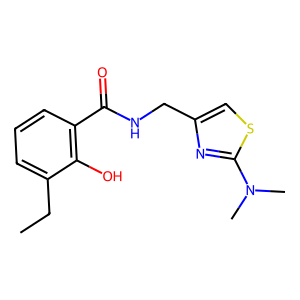

In [21]:
def generate_smiles(model, tokenizer, descriptor, max_length=100, temperature=1.0):
    model.eval()
    device = next(model.parameters()).device

    # <BOS>トークンからスタート
    input_ids = torch.tensor([[tokenizer.vocab[tokenizer.bos_token]]], device=device)
    descriptor = descriptor.to(device).unsqueeze(0)  # (1, desc_dim)

    generated = []

    with torch.no_grad():
        for _ in range(max_length):
            logits = model(input_ids, descriptor) 
            next_token_logits = logits[:, -1, :] / temperature
            next_token_probs = torch.softmax(next_token_logits, dim=-1)

            next_token = torch.multinomial(next_token_probs, num_samples=1)
            next_token_id = next_token.item()

            if next_token_id == tokenizer.vocab[tokenizer.eos_token]:
                break

            generated.append(next_token_id)

            input_ids = torch.cat([input_ids, next_token], dim=1)

    generated_smiles = tokenizer.decode(generated)
    return generated_smiles

from rdkit import Chem
from rdkit.Chem import Draw
test_smiles = "CC(=O)Nc1ccc(cc1)O"  #acetoaminophen
test_descriptor = torch.tensor(get_descriptor(test_smiles), dtype=torch.float32)

generated_smiles = generate_smiles(model, tokenizer, test_descriptor)
print("Generated SMILES:", generated_smiles)

mol = Chem.MolFromSmiles(generated_smiles)
Draw.MolToImage(mol)



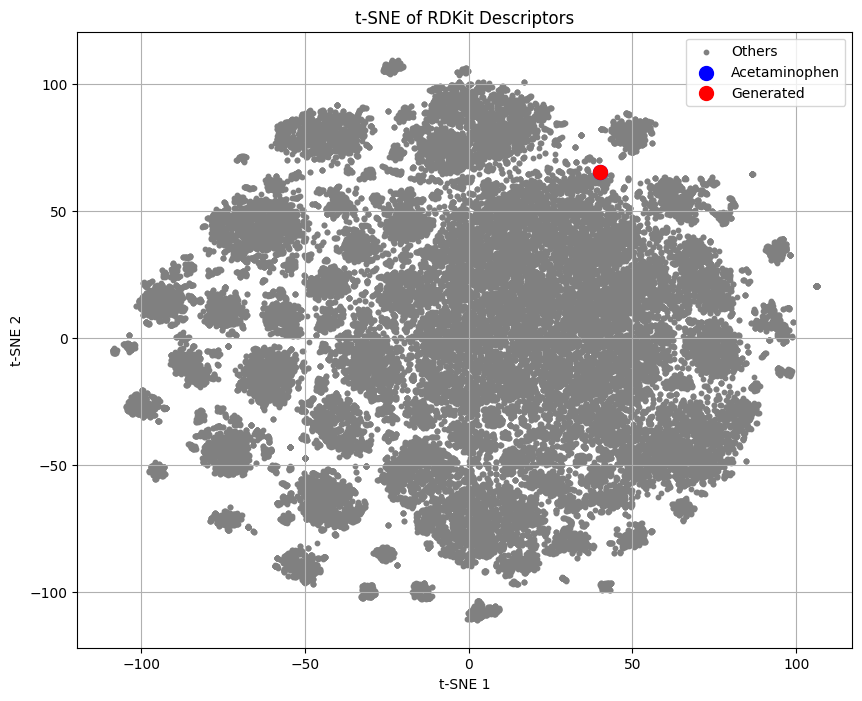

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from rdkit import Chem
from rdkit.Chem import Draw

# 1. アセトアミノフェンと生成分子の RDKit 記述子を取得
smiles_real = "CC(=O)Nc1ccc(cc1)O"
smiles_fake = generated_smiles  

desc_real = get_descriptor(smiles_real)
desc_fake = get_descriptor(smiles_fake)

# 2. 全体の記述子データを numpy 配列に（例えば descriptor_data に既にあると仮定）
all_descriptors = np.array(descriptor_data_scaled) 
all_descriptors = np.vstack([all_descriptors[:50000], desc_real, desc_fake])  # append both

# 3. t-SNE 実行
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(all_descriptors)

# 4. 可視化
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:-2, 0], tsne_result[:-2, 1], c='gray', s=10, label='Others')
plt.scatter(tsne_result[-2, 0], tsne_result[-2, 1], color='blue', s=100, label='Acetaminophen')
plt.scatter(tsne_result[-1, 0], tsne_result[-1, 1], color='red', s=100, label='Generated')

plt.title('t-SNE of RDKit Descriptors')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(True)
plt.show()


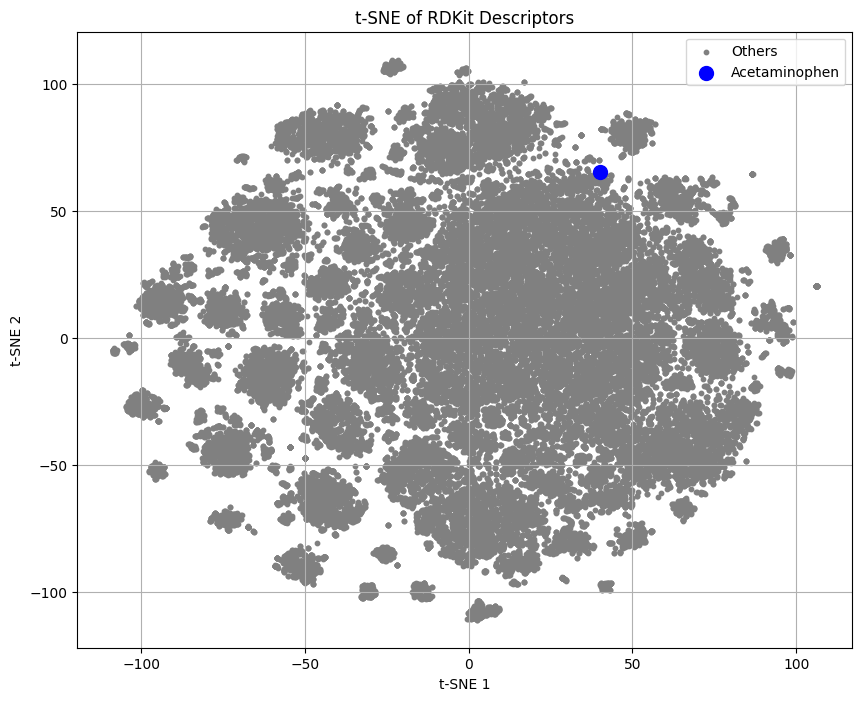

In [47]:
# 4. 可視化
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:-2, 0], tsne_result[:-2, 1], c='gray', s=10, label='Others')
plt.scatter(tsne_result[-2, 0], tsne_result[-2, 1], color='blue', s=100, label='Acetaminophen')
#plt.scatter(tsne_result[-1, 0], tsne_result[-1, 1], color='red', s=100, label='Generated')

plt.title('t-SNE of RDKit Descriptors')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(True)
plt.show()

Generated SMILES: COc1ccccc1-c1csc(NC(=O)c2ccc(Br)s2)n1


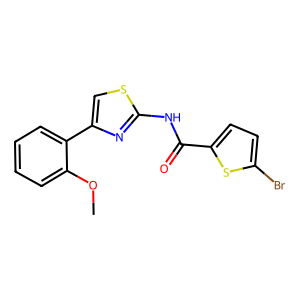

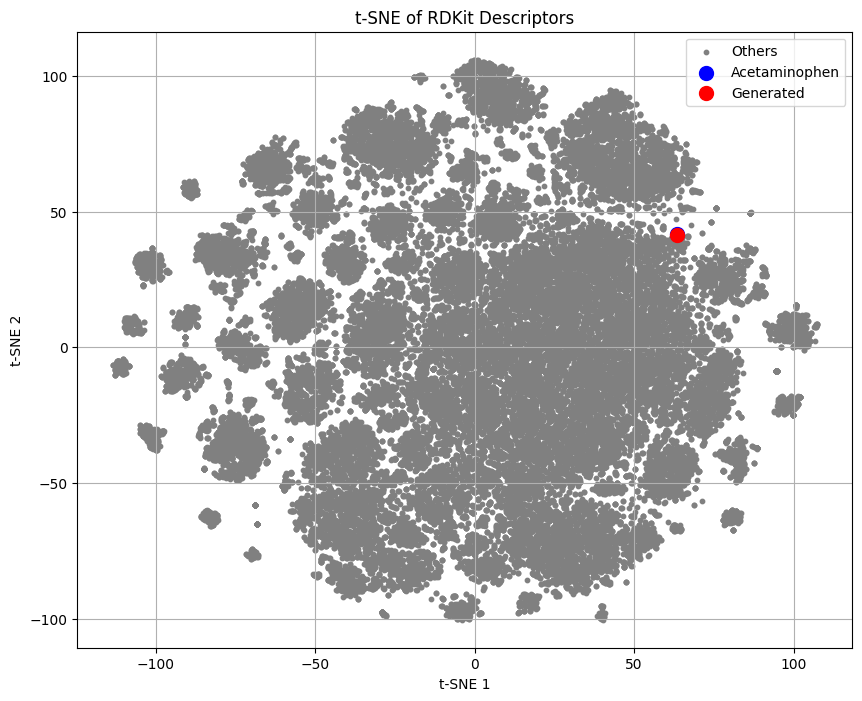

In [41]:
from rdkit import Chem
from rdkit.Chem import Draw
test_smiles = "CS(=O)(=O)C1=CC(=C(C=C1)C(=O)NC2=CC(=C(C=C2)Cl)C3=CC=CC=N3)Cl"  #bismodegib
test_descriptor = torch.tensor(get_descriptor(test_smiles), dtype=torch.float32)

generated_smiles = generate_smiles(model, tokenizer, test_descriptor)
print("Generated SMILES:", generated_smiles)

mol = Chem.MolFromSmiles(generated_smiles)
display(Draw.MolToImage(mol))

smiles_real = test_smiles
smiles_fake = generated_smiles  

desc_real = get_descriptor(smiles_real)
desc_fake = get_descriptor(smiles_fake)

# 2. 全体の記述子データを numpy 配列に（例えば descriptor_data に既にあると仮定）
all_descriptors = np.array(descriptor_data_scaled) 
all_descriptors = np.vstack([all_descriptors[:50000], desc_real, desc_fake])  # append both

# 3. t-SNE 実行
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(all_descriptors)

# 4. 可視化
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:-2, 0], tsne_result[:-2, 1], c='gray', s=10, label='Others')
plt.scatter(tsne_result[-2, 0], tsne_result[-2, 1], color='blue', s=100, label='Acetaminophen')
plt.scatter(tsne_result[-1, 0], tsne_result[-1, 1], color='red', s=100, label='Generated')

plt.title('t-SNE of RDKit Descriptors')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(True)
plt.show()


Generated SMILES: Cc1ccc(CS(=O)(=O)N2CCC(C(=O)NCCCc3ccccc3)CC2)cc1


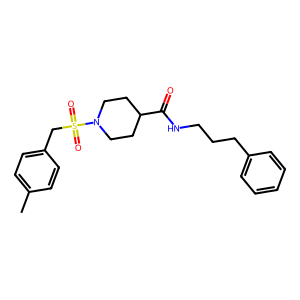

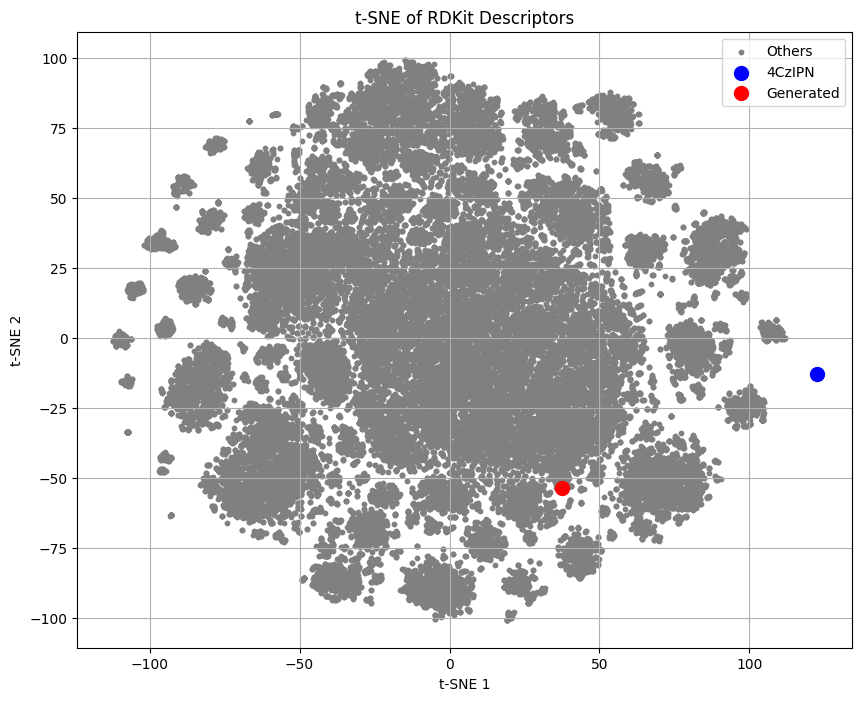

In [44]:
from rdkit import Chem
from rdkit.Chem import Draw
test_smiles = "C1=CC=C2C(=C1)C3=CC=CC=C3N2C4=C(C(=C(C(=C4C#N)N5C6=CC=CC=C6C7=CC=CC=C75)N8C9=CC=CC=C9C1=CC=CC=C18)N1C2=CC=CC=C2C2=CC=CC=C21)C#N"  #4CzIPN
test_descriptor = torch.tensor(get_descriptor(test_smiles), dtype=torch.float32)

generated_smiles = generate_smiles(model, tokenizer, test_descriptor)
print("Generated SMILES:", generated_smiles)

mol = Chem.MolFromSmiles(generated_smiles)
display(Draw.MolToImage(mol))

smiles_real = test_smiles
smiles_fake = generated_smiles  

desc_real = get_descriptor(smiles_real)
desc_fake = get_descriptor(smiles_fake)

# 2. 全体の記述子データを numpy 配列に（例えば descriptor_data に既にあると仮定）
all_descriptors = np.array(descriptor_data_scaled) 
all_descriptors = np.vstack([all_descriptors[:50000], desc_real, desc_fake])  # append both

# 3. t-SNE 実行
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(all_descriptors)

# 4. 可視化
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:-2, 0], tsne_result[:-2, 1], c='gray', s=10, label='Others')
plt.scatter(tsne_result[-2, 0], tsne_result[-2, 1], color='blue', s=100, label='4CzIPN')
plt.scatter(tsne_result[-1, 0], tsne_result[-1, 1], color='red', s=100, label='Generated')

plt.title('t-SNE of RDKit Descriptors')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(True)
plt.show()


Generated SMILES: O=C(N1C=C(C(=O)[O-])C1)c1ccc2ncccc2c1


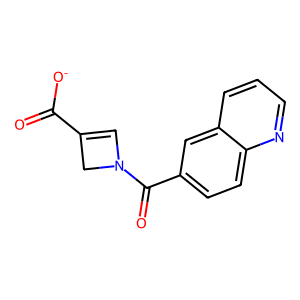

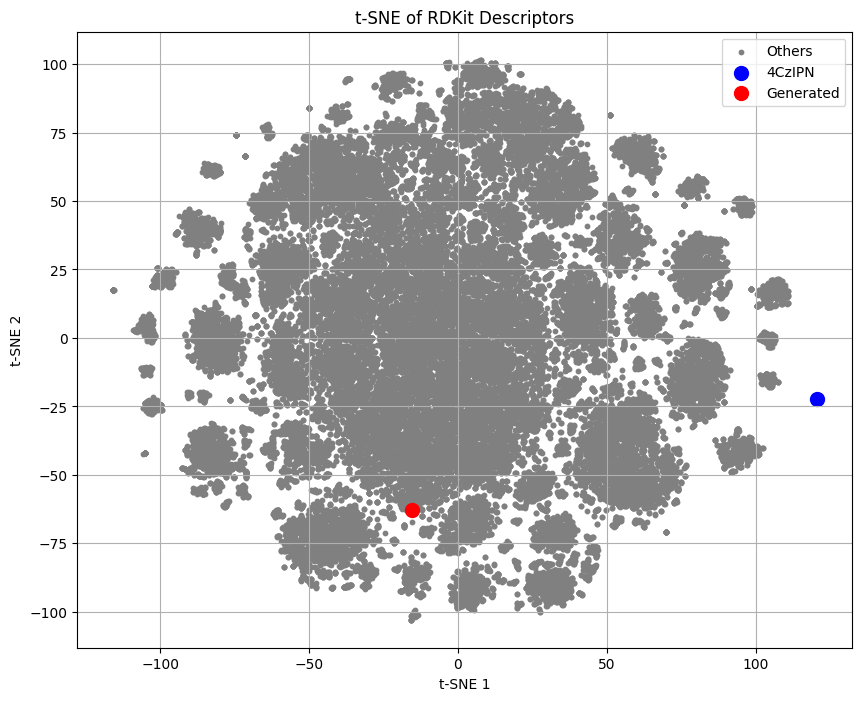

In [45]:
from rdkit import Chem
from rdkit.Chem import Draw
test_smiles = "C1=CC=C2C(=C1)C3=CC=CC=C3N2C4=C(C(=C(C(=C4C#N)N5C6=CC=CC=C6C7=CC=CC=C75)N8C9=CC=CC=C9C1=CC=CC=C18)N1C2=CC=CC=C2C2=CC=CC=C21)C#N"  #4CzIPN
test_descriptor = torch.tensor(get_descriptor(test_smiles), dtype=torch.float32)

generated_smiles = generate_smiles(model, tokenizer, test_descriptor)
print("Generated SMILES:", generated_smiles)

mol = Chem.MolFromSmiles(generated_smiles)
display(Draw.MolToImage(mol))

smiles_real = test_smiles
smiles_fake = generated_smiles  

desc_real = get_descriptor(smiles_real)
desc_fake = get_descriptor(smiles_fake)

# 2. 全体の記述子データを numpy 配列に（例えば descriptor_data に既にあると仮定）
all_descriptors = np.array(descriptor_data_scaled) 
all_descriptors = np.vstack([all_descriptors[:50000], desc_real, desc_fake])  # append both

# 3. t-SNE 実行
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(all_descriptors)

# 4. 可視化
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:-2, 0], tsne_result[:-2, 1], c='gray', s=10, label='Others')
plt.scatter(tsne_result[-2, 0], tsne_result[-2, 1], color='blue', s=100, label='4CzIPN')
plt.scatter(tsne_result[-1, 0], tsne_result[-1, 1], color='red', s=100, label='Generated')

plt.title('t-SNE of RDKit Descriptors')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
model2= MolGPT_SelfAttention(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    padding_idx=padding_idx,
    n_heads=n_heads,
    feedforward_dim=feedforward_dim,
    n_layers=n_layers,
    desc_size=desc_size
).to(device)
model2.load_state_dict(torch.load("molgpt_final_model_ep100.pth"))

# 推論やテスト時は eval モードにする
model2.eval()

MolGPT_SelfAttention(
  (embedder): Embedder(
    (embedding): Embedding(98, 256, padding_idx=2)
  )
  (descriptor_encoder): DescriptorEncoder(
    (bit_emb): Embedding(217, 256)
    (scale_norm): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (positional_encoder): PositionalEncoder()
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-7): 8 x TransformerBlock(
      (self_attn): SelfAttentionLayer(
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
      )
      (feed_forward): FeedForwardLayer(
        (feedforward): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-

Generated SMILES: Cc1cc(F)ccc1CCNC(=O)CCc1nc(C2CC2)no1


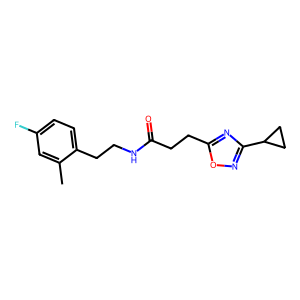

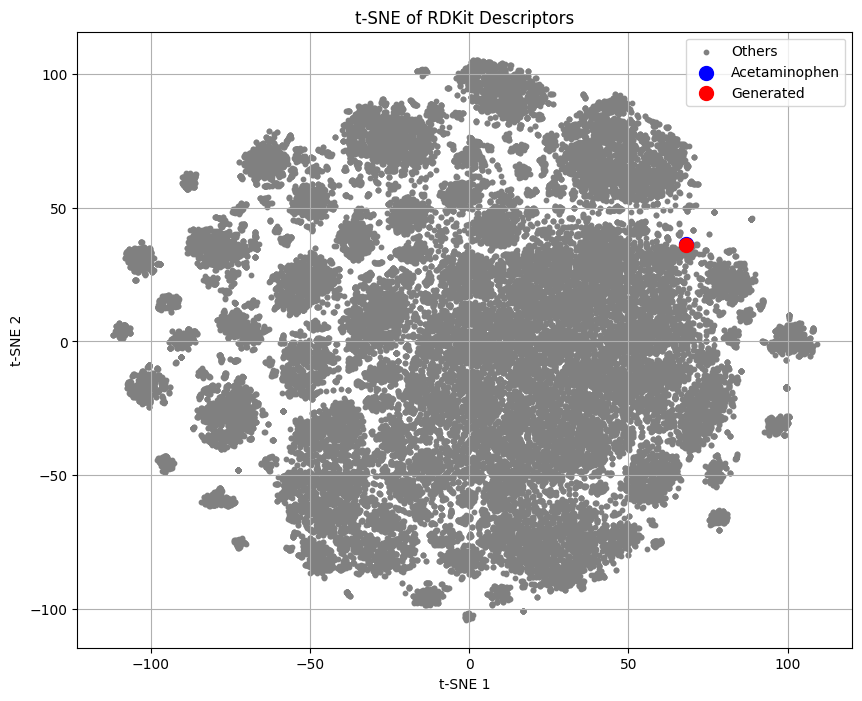

In [51]:
from rdkit import Chem
from rdkit.Chem import Draw
test_smiles = "CS(=O)(=O)C1=CC(=C(C=C1)C(=O)NC2=CC(=C(C=C2)Cl)C3=CC=CC=N3)Cl"  #bismodegib
test_descriptor = torch.tensor(get_descriptor(test_smiles), dtype=torch.float32)

generated_smiles = generate_smiles(model2, tokenizer, test_descriptor)
print("Generated SMILES:", generated_smiles)

mol = Chem.MolFromSmiles(generated_smiles)
display(Draw.MolToImage(mol))

smiles_real = test_smiles
smiles_fake = generated_smiles  

desc_real = get_descriptor(smiles_real)
desc_fake = get_descriptor(smiles_fake)

# 2. 全体の記述子データを numpy 配列に（例えば descriptor_data に既にあると仮定）
all_descriptors = np.array(descriptor_data_scaled) 
all_descriptors = np.vstack([all_descriptors[:50000], desc_real, desc_fake])  # append both

# 3. t-SNE 実行
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(all_descriptors)

# 4. 可視化
plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:-2, 0], tsne_result[:-2, 1], c='gray', s=10, label='Others')
plt.scatter(tsne_result[-2, 0], tsne_result[-2, 1], color='blue', s=100, label='Acetaminophen')
plt.scatter(tsne_result[-1, 0], tsne_result[-1, 1], color='red', s=100, label='Generated')

plt.title('t-SNE of RDKit Descriptors')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(True)
plt.show()
